In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Question1
## (b)data processing

In [198]:
name=[i.split(':') for i in open('communities.txt').readlines() if ':'in i and '--' in i][2:]
name=[i[0][3:] for i in name]
df=pd.read_csv('communities.csv',names=name)
df.replace('?',np.nan,inplace=True)
df.iloc[:,5:]=df.iloc[:,5:].astype('float',inplace=True)
df.interpolate(method='akima',inplace=True)

In [199]:
train=df.iloc[:1495,5:].reset_index(drop=True)
test=df.iloc[1495:,5:].reset_index(drop=True)

## (c)correlation matrix

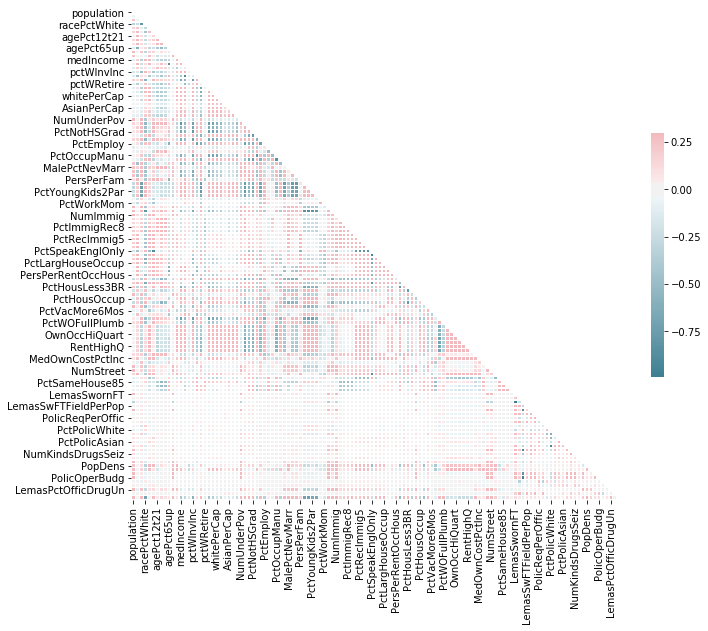

In [185]:
corr=train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## (d)CV

In [378]:
CV=pd.DataFrame(name[5:],columns=['feature'])
for i in CV['feature']:
    CV.loc[CV['feature']==i,'CV']=np.std(df[i])/np.mean(df[i])
CV

,feature,CV
0,population,2.202950
1,householdsize,0.353210
2,racepctblack,1.410567
3,racePctWhite,0.323700
4,racePctAsian,1.358821
5,racePctHisp,1.613873
6,agePct12t21,0.365748
7,agePct12t29,0.290620
8,agePct16t24,0.495036
9,agePct65up,0.423336


## (e)pick feature

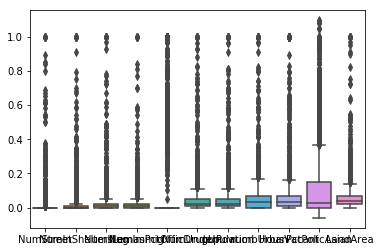

In [379]:
select=CV.nlargest(11,'CV')['feature']
ax = sns.boxplot(data=df.loc[:,select])

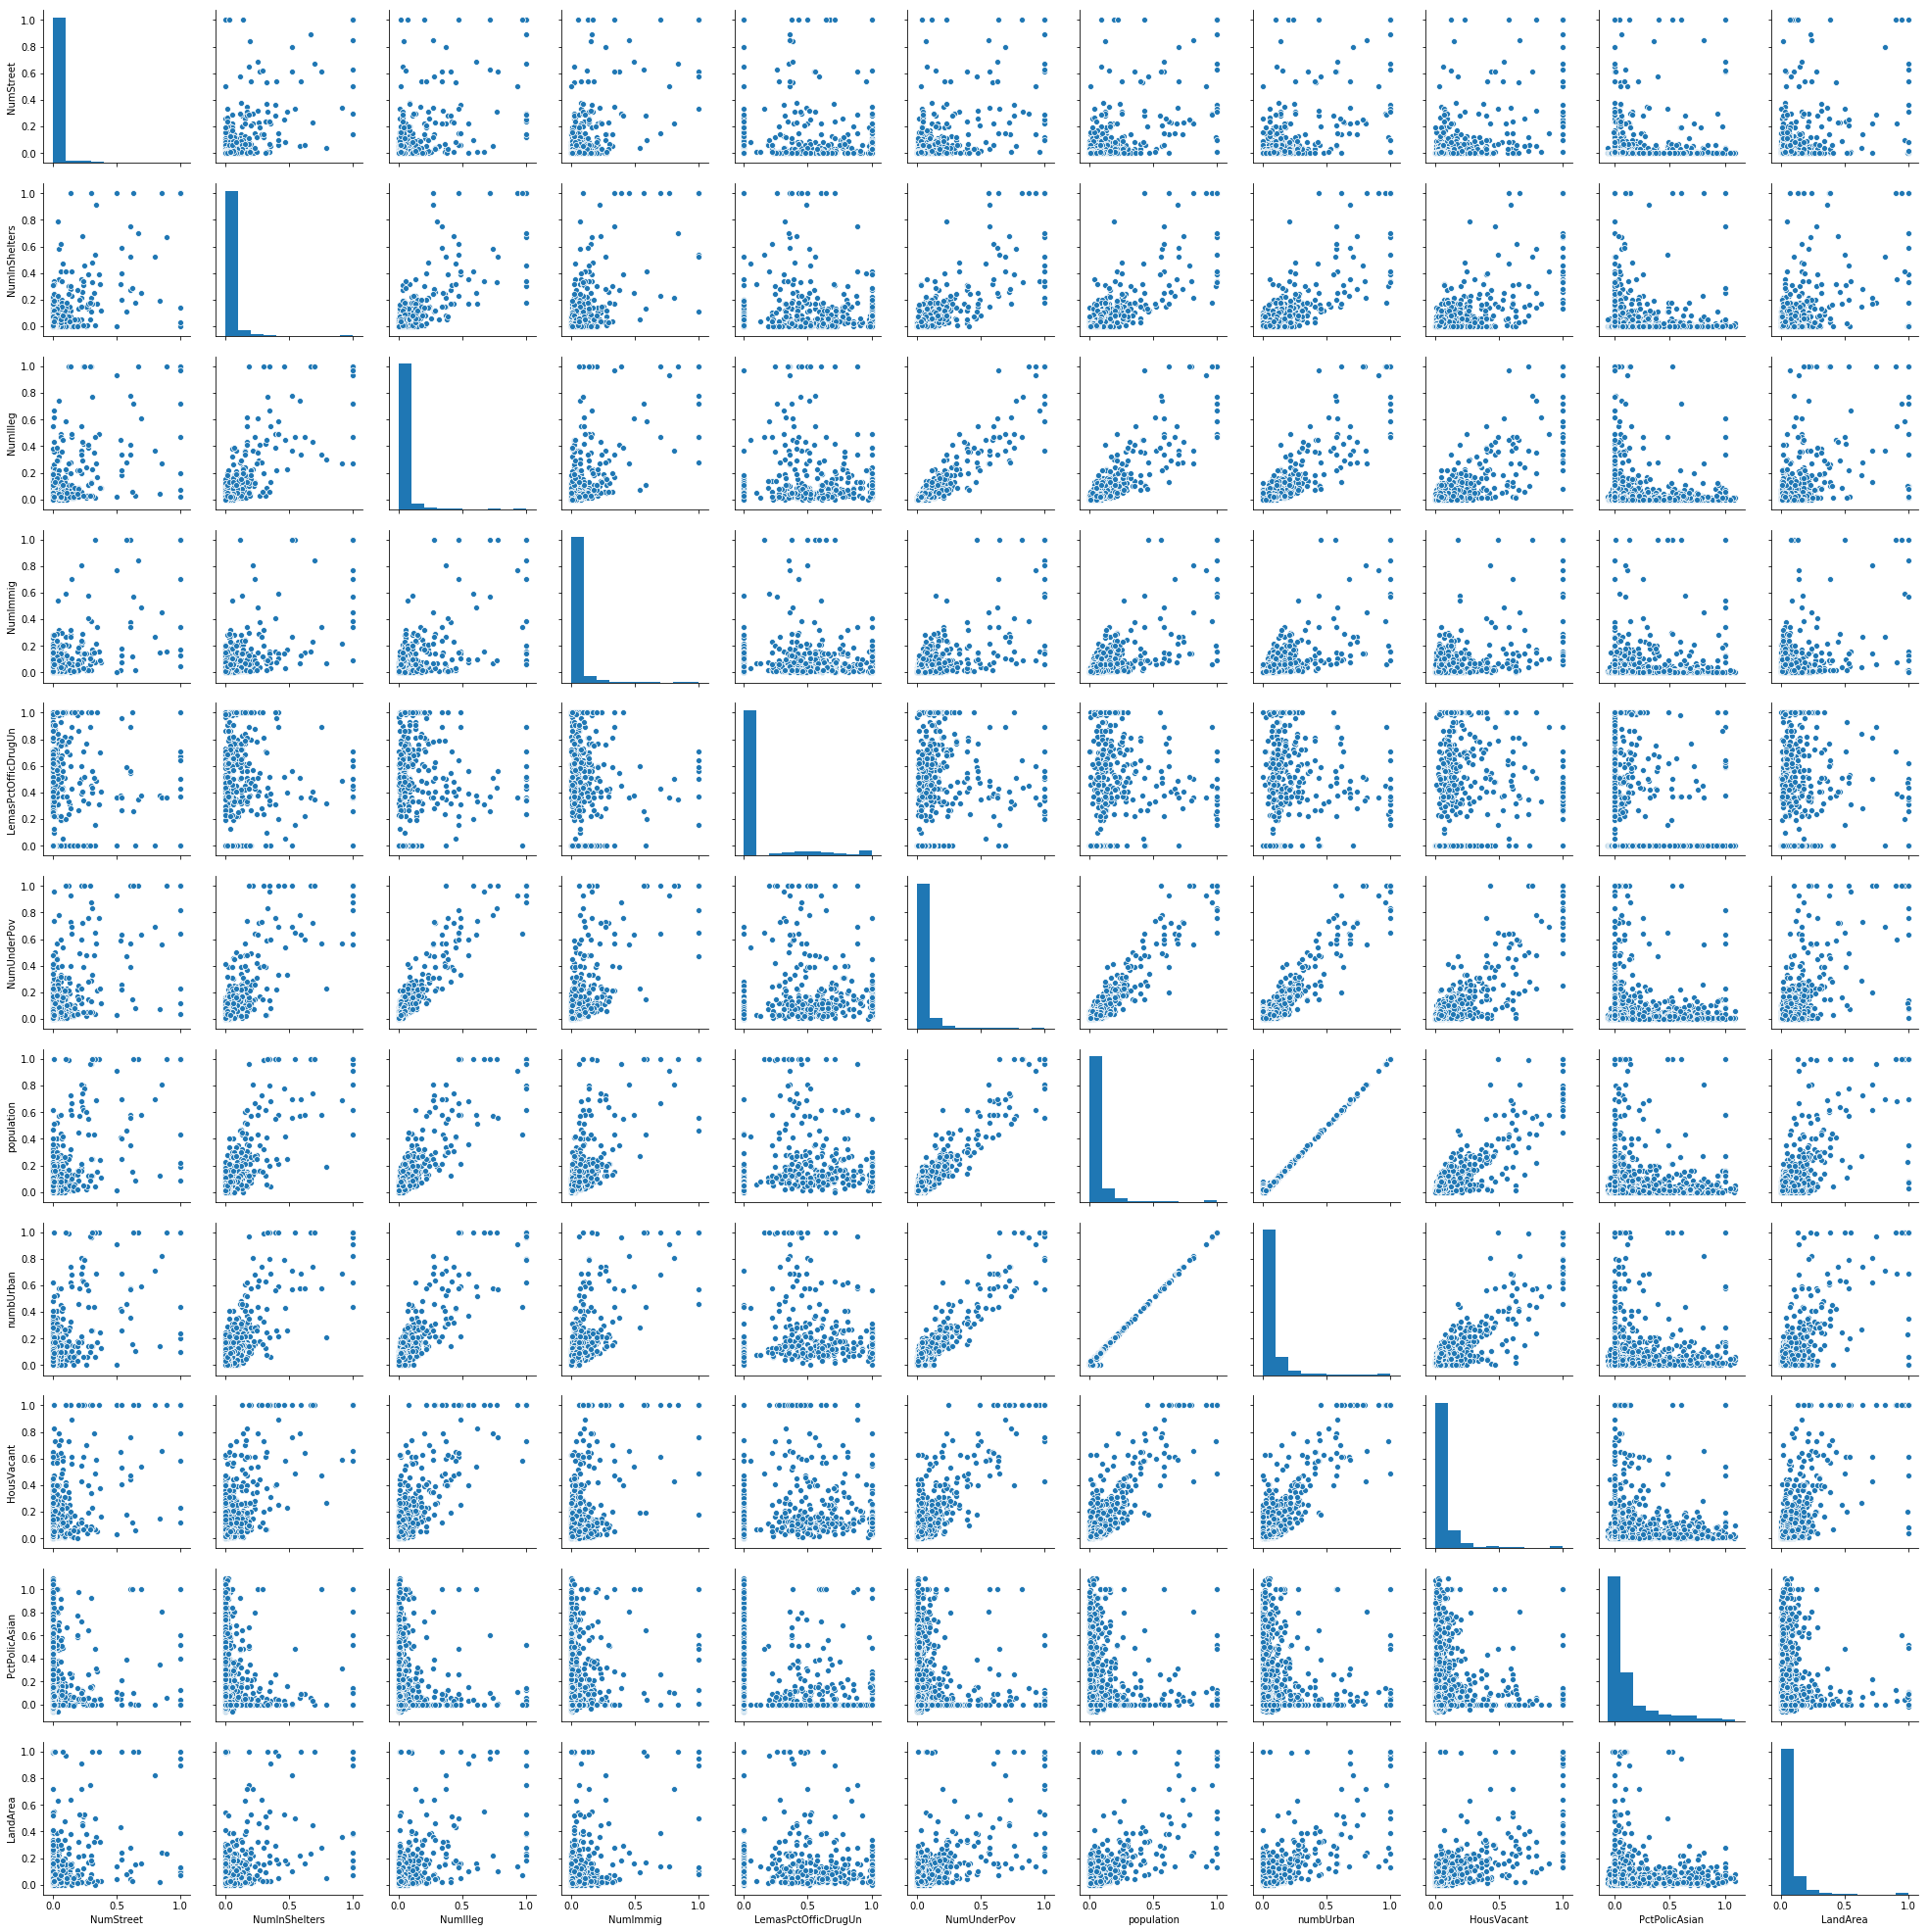

In [380]:
sns.pairplot(df.loc[:,select])

## (f)linear regression

In [209]:
reg1=linear_model.LinearRegression()
reg1.fit(train.loc[:,select],train['ViolentCrimesPerPop'])
pred=reg1.predict(test.loc[:,select])
true=np.array(test['ViolentCrimesPerPop'])
mean_squared_error(true,pred)

0.031782754945305136

## (g)ridge regression

In [245]:
alphas = 10**np.linspace(-3,3,100)
ridge_cv=RidgeCV(alphas=alphas, normalize=True, scoring='neg_mean_squared_error', cv=10)
ridge_cv.fit(train.loc[:,select],train['ViolentCrimesPerPop'])
pred_ridge=ridge_cv.predict(test.loc[:,select])
mean_squared_error(true,pred_ridge)

0.03144176968056886

# (h) LASSO

In [263]:
lasso_cv=LassoCV()
lasso_cv.fit(train.iloc[:,:-1],train['ViolentCrimesPerPop'])
pred_lasso=lasso_cv.predict(test.iloc[:,:-1])
coef = pd.Series(lasso_cv.coef_, index = train.iloc[:,:-1].columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + 
      str(sum(coef == 0)) + " variables"+" The MSE is "+str(mean_squared_error(true,pred_lasso)))
coef[coef != 0]

C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso picked 50 variables and eliminated the other 72 variables The MSE is 0.01762486119105963


racepctblack             0.246401
agePct12t29             -0.055837
pctUrban                 0.038093
pctWWage                -0.024547
pctWFarmSelf             0.008194
pctWInvInc              -0.036048
pctWPubAsst              0.029088
pctWRetire              -0.071622
blackPerCap             -0.008915
indianPerCap            -0.022100
AsianPerCap              0.022420
OtherPerCap              0.014774
HispPerCap               0.003747
PctPopUnderPov          -0.066327
PctEmploy                0.003665
MalePctDivorce           0.092912
PctKids2Par             -0.222967
PctYoungKids2Par        -0.036940
PctTeen2Par             -0.002226
PctWorkMom              -0.076373
PctIlleg                 0.122426
PctImmigRec5            -0.000692
PctRecImmig10            0.005311
PctPersOwnOccup         -0.007995
PctPersDenseHous         0.140584
PctHousLess3BR           0.045111
HousVacant               0.090070
PctHousOccup            -0.065052
PctVacantBoarded         0.061614
PctVacMore6Mos

## （h) standradized data

In [276]:
df_std=df.iloc[:,5:]
df_std=(df_std - df_std.min()) / (df_std.max() - df_std.min())
train_std=df_std.iloc[:1495,:].reset_index(drop=True)
test_std=df_std.iloc[1495:,:].reset_index(drop=True)

In [278]:
lasso_cv=LassoCV()
lasso_cv.fit(train_std.iloc[:,:-1],train_std['ViolentCrimesPerPop'])
pred_lasso=lasso_cv.predict(test_std.iloc[:,:-1])
coef = pd.Series(lasso_cv.coef_, index = train.iloc[:,:-1].columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + 
      str(sum(coef == 0)) + " variables"+" The MSE is "+str(mean_squared_error(true,pred_lasso)))
coef[coef != 0]

C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

Lasso picked 51 variables and eliminated the other 71 variables The MSE is 0.017580287367912686


racepctblack             0.252130
agePct12t29             -0.064266
pctUrban                 0.037789
pctWWage                -0.038986
pctWFarmSelf             0.011870
pctWInvInc              -0.043693
pctWPubAsst              0.025994
pctWRetire              -0.076779
blackPerCap             -0.011935
indianPerCap            -0.025294
AsianPerCap              0.022105
OtherPerCap              0.017981
HispPerCap               0.006630
PctPopUnderPov          -0.078094
PctEmploy                0.020765
MalePctDivorce           0.091917
MalePctNevMarr           0.010439
PctKids2Par             -0.216934
PctYoungKids2Par        -0.041192
PctTeen2Par             -0.001772
PctWorkMom              -0.084704
PctIlleg                 0.118145
PctImmigRec5            -0.001427
PctRecImmig10            0.007456
PctPersOwnOccup         -0.009250
PctPersDenseHous         0.144295
PctHousLess3BR           0.047574
HousVacant               0.089529
PctHousOccup            -0.067011
PctVacantBoard

## (i)PCR model

In [288]:
pca=PCA(n_components='mle')
newX=pca.fit_transform(df.iloc[:,5:-1])
train_pca=newX[:1495]
test_pca=newX[1495:]
reg2=linear_model.LinearRegression()
reg1.fit(train_pca,train['ViolentCrimesPerPop'])
pred=reg1.predict(test_pca)
true=np.array(test['ViolentCrimesPerPop'])
mean_squared_error(true,pred)

## (j) XGboosting tree

In [300]:
model=XGBClassifier()
model.fit(train.iloc[:,:-1],train['ViolentCrimesPerPop'])
pred_xgb=model.predict(test.iloc[:,:-1])
mean_squared_error(true,pred_xgb)

0.03242264529058117

# Question2
## (b) data preparation
### (i) NA filling

In [463]:
train=pd.read_csv('aps_failure_training_set.csv',skiprows=20)
test=pd.read_csv('aps_failure_test_set.csv',skiprows=20)

In [464]:
train.replace('na',np.nan,inplace=True)
train_x=train.iloc[:,1:].astype('float',inplace=True)
train_y=train.iloc[:,0]=='pos'
test.replace('na',np.nan,inplace=True)
test_x=test.iloc[:,1:].astype('float',inplace=True)
test_y=test.iloc[:,0]=='pos'

In [465]:
train_x.fillna(method='bfill',inplace=True)
test_x.fillna(method='bfill',inplace=True)
train_x.fillna(method='ffill',inplace=True)
test_x.fillna(method='ffill',inplace=True)

### (ii) CV 

In [394]:
CV=pd.DataFrame(train_x.columns,columns=['feature'])
for i in CV['feature']:
    CV.loc[CV['feature']==i,'CV']=np.std(train_x[i])/np.mean(train_x[i])
CV

,feature,CV
0,aa_000,2.450917
1,ab_000,4.659718
2,ac_000,2.232851
3,ad_000,244.147658
4,ae_000,23.298547
5,af_000,18.854017
6,ag_000,92.916896
7,ag_001,35.107606
8,ag_002,17.432864
9,ag_003,8.606906


### (iii) correlation matrix

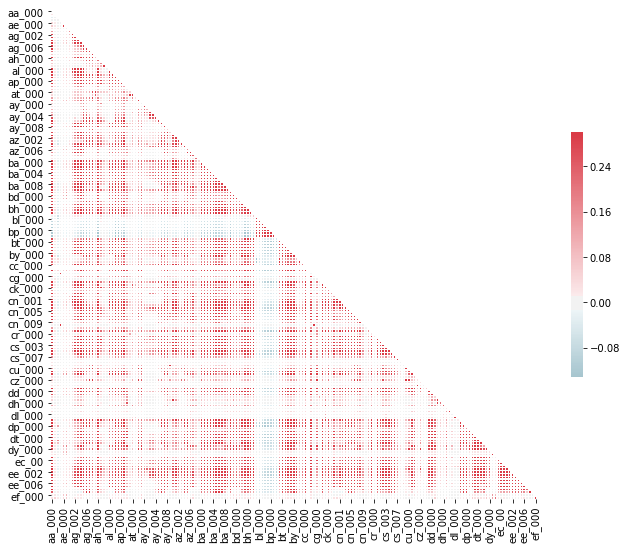

In [353]:
corr=train_x.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

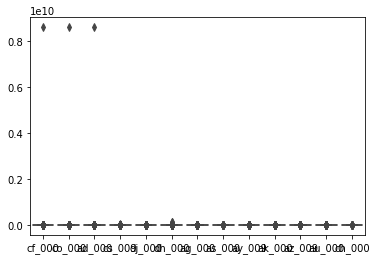

In [383]:
select=CV.nlargest(13,'CV')['feature']
ax = sns.boxplot(data=train_x.loc[:,select])

### (iv) pick feature

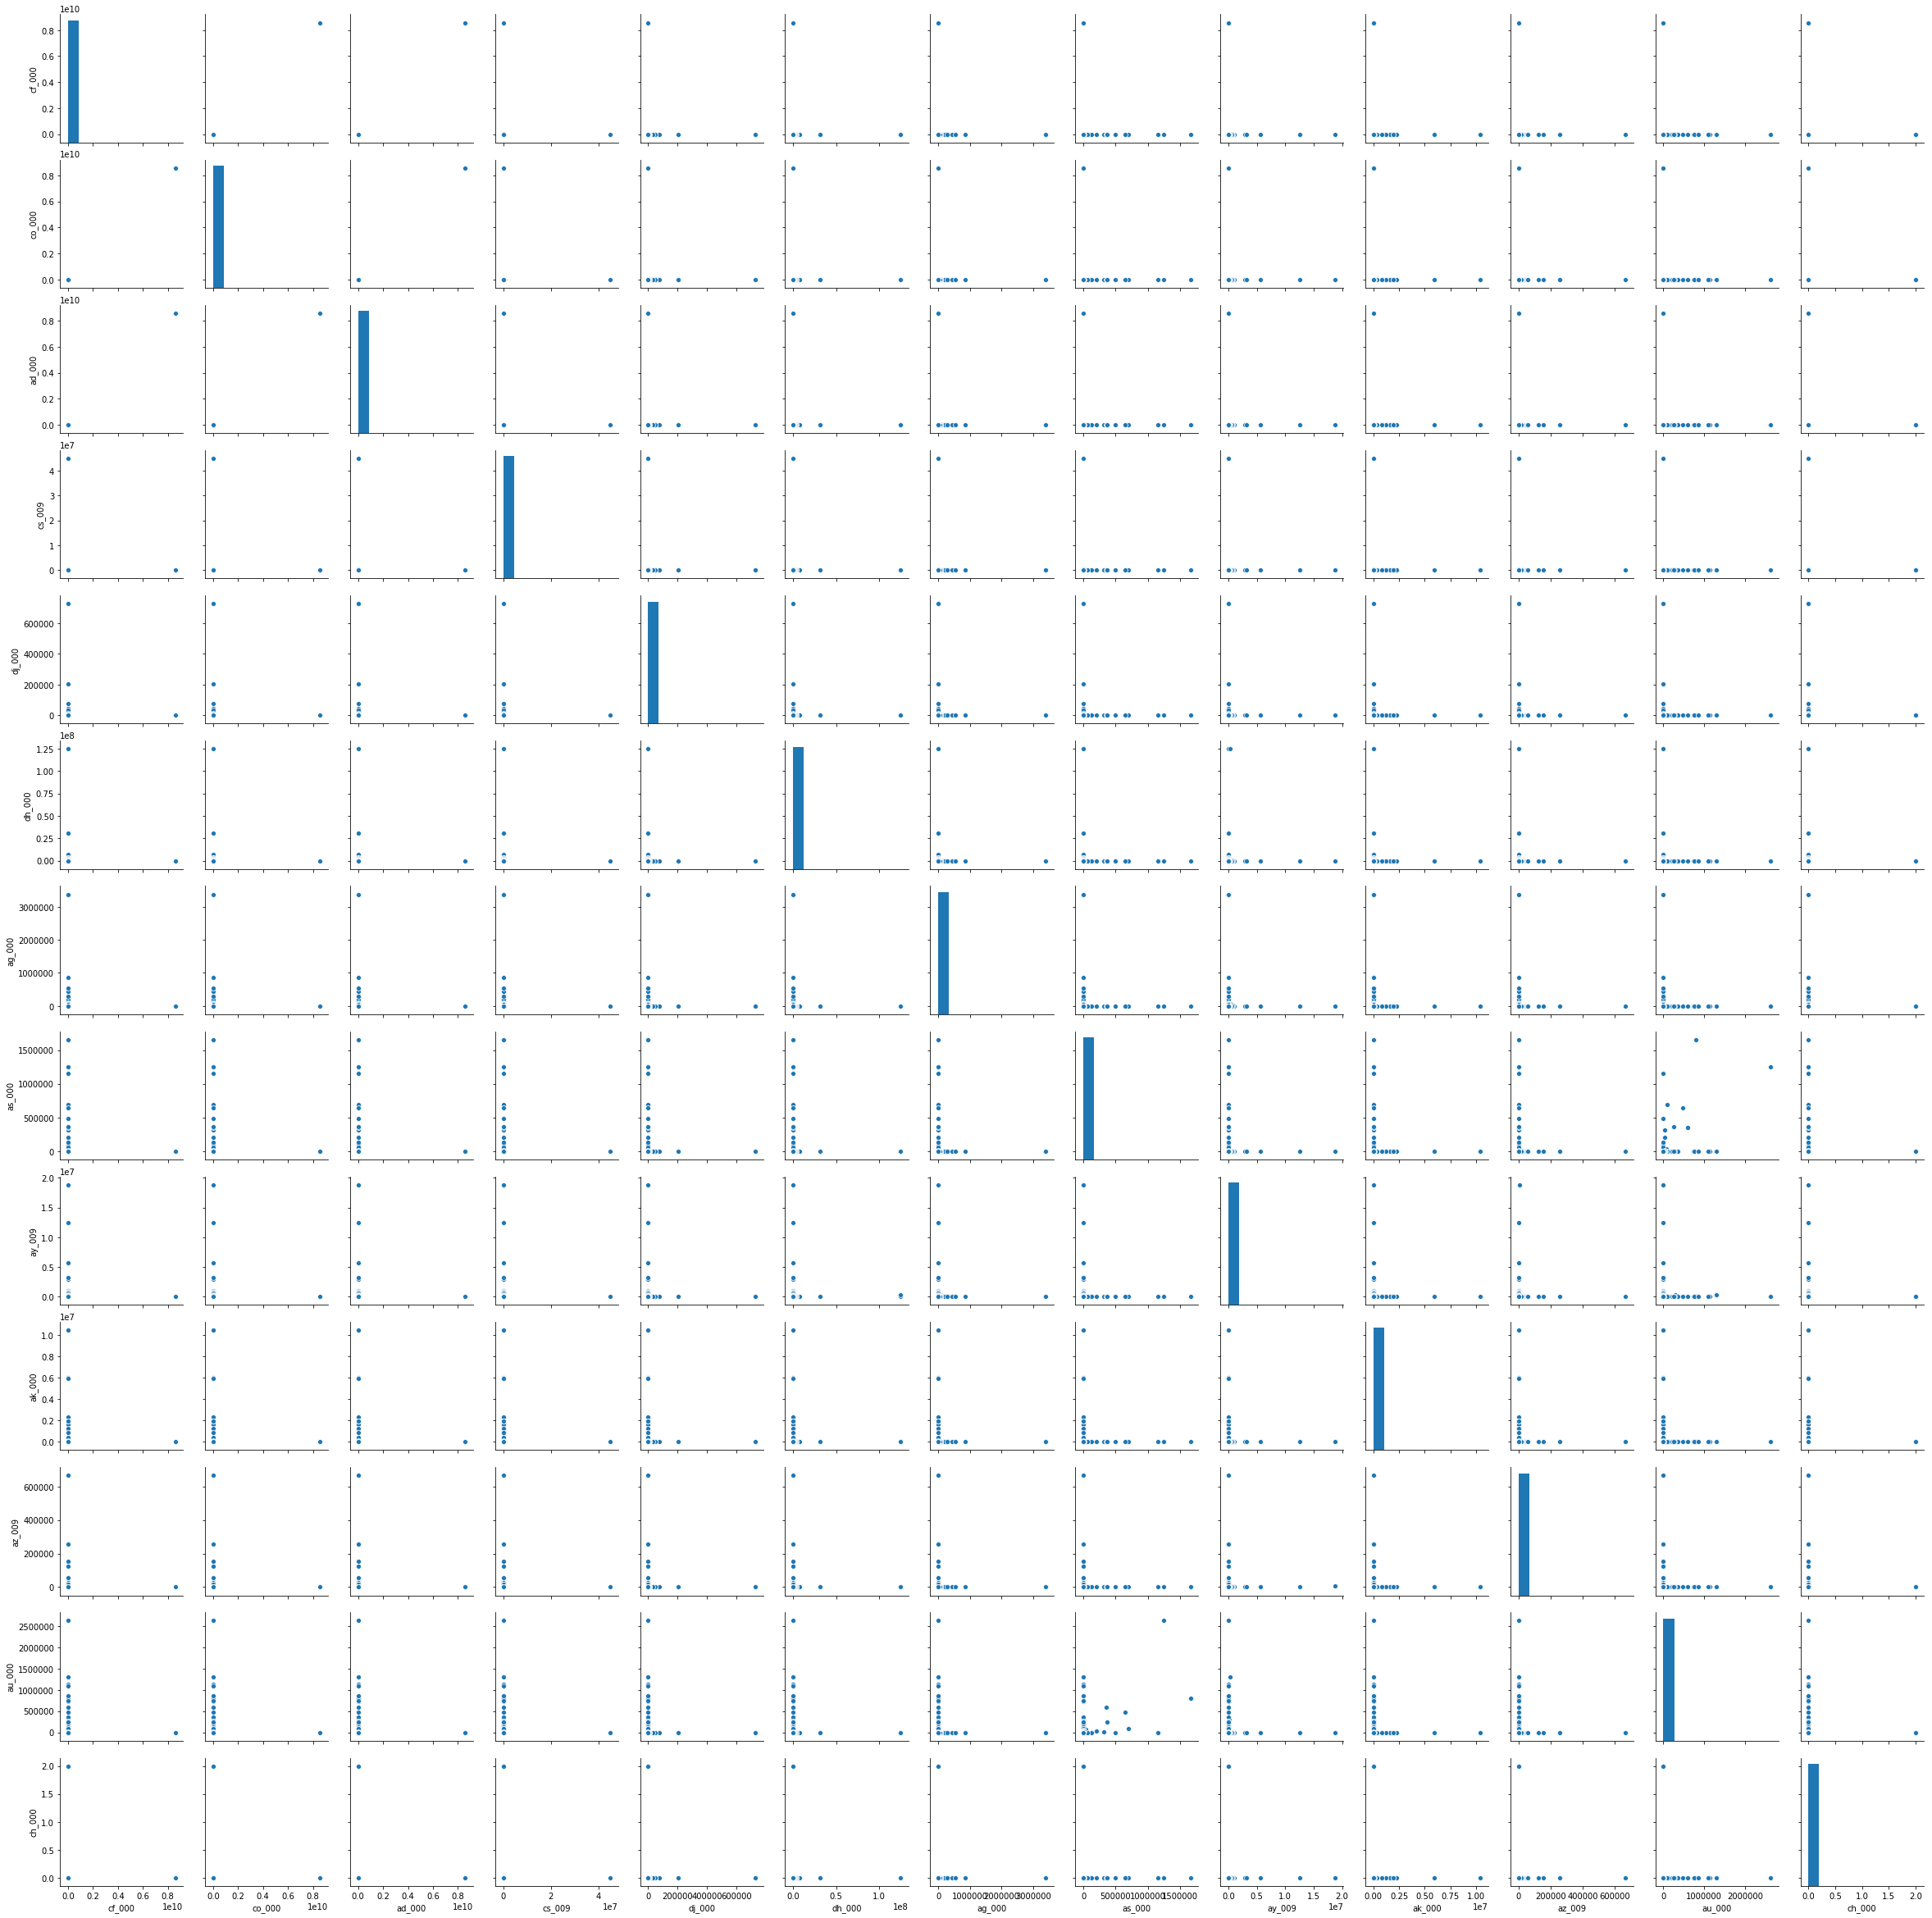

In [366]:
sns.pairplot(train_x.loc[:,select])

### (v) numbers of positive and negtive data

In [438]:
positive=sum(test_y)
negative=len(test_y)-positive
print('the positive number is: {}'.format(positive)+'\nthe negative number is: {}'.format(negative)+'\nTherefore, it\'s imbalance')

the positive number is: 375
the negative number is: 15625
Therefore, it's imbalance


## (c) Random Forest

In [505]:
clf = RandomForestClassifier(oob_score=True,warm_start=True)
clf.fit(train_x,train_y)
pred = clf.predict(test_x)

C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [509]:
c=confusion_matrix(test_y,pred)
print(c)

[[15608    17]
 [  131   244]]


<Figure size 432x288 with 0 Axes>

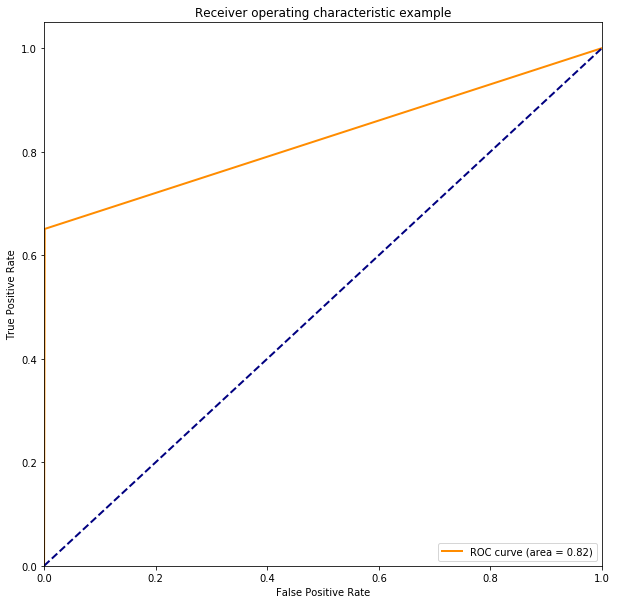

roc_auc:0.8247893333333333
oob error: 0.009533333333333283
test error: 0.00925


In [515]:
test_yB=label_binarize(test_y,classes=clf.classes_)
fpr, tpr, threshold = roc_curve(test_yB, pred)
test_error=(c[1][0]+c[0][1])/16000
roc_auc = auc(fpr, tpr)
oob_error=1-clf.oob_score_
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('roc_auc:{}'.format(roc_auc)+'\noob error: {}'.format(oob_error)+'\ntest error: {}'.format(test_error))

## (d) compensate imbalance sample

In [538]:

clf = RandomForestClassifier(max_depth=100,oob_score=True,warm_start=True,class_weight={True:1,False:59})
model = clf.fit(train_x,train_y)
pred = clf.predict(test_x)

C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [539]:
c=confusion_matrix(test_y,pred)
print(c)

[[15602    23]
 [  123   252]]


<Figure size 432x288 with 0 Axes>

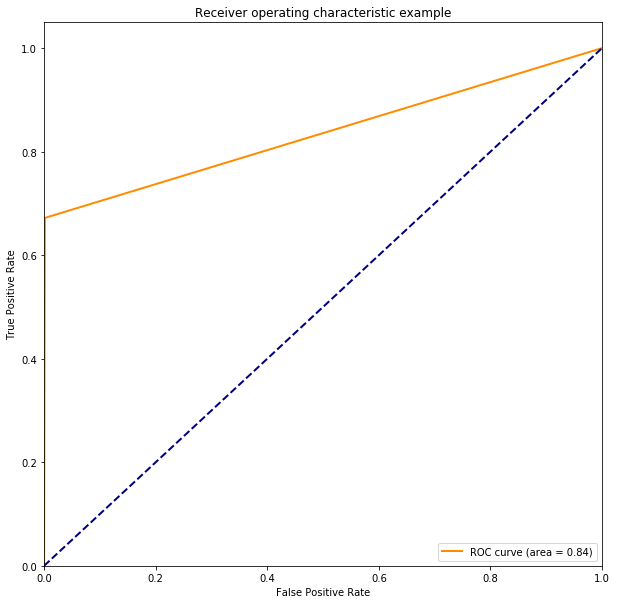

roc_auc:0.8352640000000001
oob error: 0.009750000000000036
test error: 0.009125


In [540]:
test_yB=label_binarize(test_y,classes=clf.classes_)
fpr, tpr, threshold = roc_curve(test_yB, pred)
test_error=(c[1][0]+c[0][1])/16000
roc_auc = auc(fpr, tpr)
oob_error=1-clf.oob_score_
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('roc_auc:{}'.format(roc_auc)+'\noob error: {}'.format(oob_error)+'\ntest error: {}'.format(test_error))

# Questione3 6.8.3
## (a) 
The result will steady decrease. Because when s is small, the model couldn't have a strong interpretibility, the residual would be very large. As s increase, the model can be optimized.
## (b)
Test RSS will decrease at first and then increase. Because the model will have over fitting problem.
## (c)
The model variance will steadily decrease because the interpretibility is increase as s increase.
## (d)
Squared bias will decrease steadily.
## (e)
irreducible error will remain the same because it can't be optimized through adjusting the parameter.

# Question4 6.8.5
## (a)
the problem is to optimize
$$F=||Y-wX||^2+\lambda||w||^2 $$
## (b)
because in the two instance,and ridge regression is actually an improvement of linear regressino, $x_1=x_2$, $\beta_1=\beta_2$
## (c)
the problem is to optimize
$$min \frac{1}{n}||y-Xw||^2, s.t.||w||<=C$$

# Question5 8.4.5
The majority vote approach results in a final classification of red because there are more estimates that are >0.5 (0.55, 0.6, 0.65, 0.7, 0.75) than there are estimates that are <0.5 (0.1, 0.15, 0.2, 0.2).

The average probability approach takes the average of the 10 estimates. The average from this set of estimates is 0.45, resulting in a final classification of green since the average estimate is <0.5.

# Question6 9.7.3
## (a)


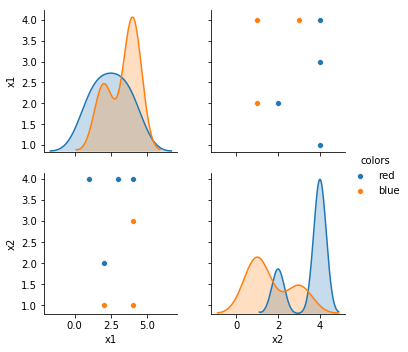

In [32]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
colors = ["red", "red", "red", "red", "blue", "blue", "blue"]
df=pd.DataFrame({'x1':x1,'x2':x2,'colors':colors})
sns.pairplot(df,hue='colors')

## (b)

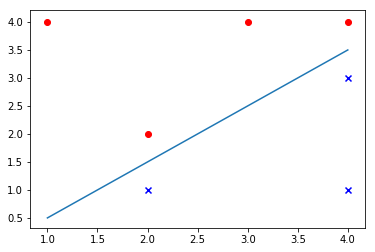

In [28]:
colors = {'red':'r', 'blue':'b'}
classes = { 'blue':'x', 'red':'o'}

for cla in classes:
    d = df[df['colors']==cla]
    plt.scatter(x='x1',y='x2',data=d,marker=classes[cla],c=colors[cla])
plt.plot([1,4],[0.5,3.5])

## (c)
The classification rule is Classify to Red if X1−X2−0.5<0, and classify to Blue otherwise.

## (d)

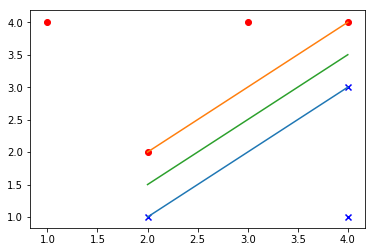

In [26]:
colors = {'red':'r', 'blue':'b'}
classes = { 'blue':'x', 'red':'o'}

for cla in classes:
    d = df[df['colors']==cla]
    plt.scatter(x='x1',y='x2',data=d,marker=classes[cla],c=colors[cla])
plt.plot([2,4],[1,3])
plt.plot([2,4],[2,4])
plt.plot([2,4],[1.5,3.5])

## (e)
The support vectors are the points (2,1), (2,2), (4,3) and (4,4)
## (f)
By examining the plot, it is clear that if we moved the observation (4,1), we would not change the maximal margin hyperplane as it is not a support vector
## (g)

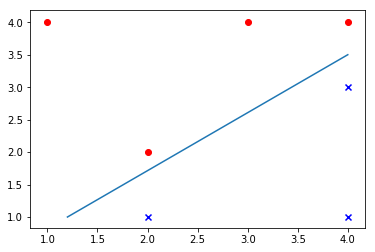

In [27]:
colors = {'red':'r', 'blue':'b'}
classes = { 'blue':'x', 'red':'o'}

for cla in classes:
    d = df[df['colors']==cla]
    plt.scatter(x='x1',y='x2',data=d,marker=classes[cla],c=colors[cla])
plt.plot([1.2,4],[1,3.5])

## (h)

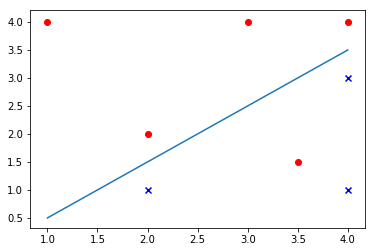

In [39]:
df.loc[7]=[3.5,1.5,'red']
colors = {'red':'r', 'blue':'b'}
classes = { 'blue':'x', 'red':'o'}

for cla in classes:
    d = df[df['colors']==cla]
    plt.scatter(x='x1',y='x2',data=d,marker=classes[cla],c=colors[cla])
plt.plot([1,4],[0.5,3.5])